<a href="https://colab.research.google.com/github/GabrielVideira/pos-tech-dados/blob/main/TC_fase2_grupo79.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo Preditivo IBOVESPA**

**Integrantes do Grupo 79:**

Leonardo Morera - RM 359111

Thais Yamazaki - RM 358560

Guilherme Gatto - RM 359558

Gabriel D'Angelo - RM 359453

Patricia Silva - RM 358415



## Introdução

A equipe de investimentos da **Aurora Capital** buscava uma maneira de aprimorar suas estratégias por meio da previsão do fechamento do índice Ibovespa. A idéia seria desenvolver um modelo preditivo que permita prever o fechamento diário do Ibovespa com uma acurácia superior a 70%, utilizando dados históricos e algoritmos de Machine Learning.

Importações

In [ ]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Coleta e tratamento dos Dados

### Fonte dos Dados

Os dados históricos do Ibovespa foram obtidos no site Investing.com, cobrindo o período de 2010 a 2025 com granularidade diária. A base incluía as seguintes variáveis:

- **Data**: Data do registro.
- **Último**: Valor de fechamento do índice.
- **Abertura**: Valor de abertura do índice.
- **Máxima**: Valor máximo diário do índice.
- **Mínima**: Valor mínimo diário do índice.
- **Var. (%)**: Variação percentual do dia.
- **Vol.**: Volume negociado no período.

In [ ]:
df_ibovespa = pd.read_csv("https://raw.githubusercontent.com/GabrielVideira/pos-tech-dados/refs/heads/main/dados/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv", encoding='utf-8', sep=',')
df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,30.12.2024,120.283,120.267,121.050,120.158,"8,90B","0,01%"
1,27.12.2024,120.269,121.078,121.609,120.252,"8,94B","-0,67%"
2,26.12.2024,121.078,120.767,121.612,120.428,"8,34B","0,26%"
3,23.12.2024,120.767,122.105,122.105,120.617,"9,95B","-1,09%"
4,20.12.2024,122.102,121.183,122.209,120.700,"18,13B","0,75%"
...,...,...,...,...,...,...,...
3712,08.01.2010,70.263,70.455,70.766,70.158,"1,63M","-0,27%"
3713,07.01.2010,70.451,70.723,70.723,70.045,"1,55M","-0,39%"
3714,06.01.2010,70.729,70.236,70.937,70.016,"2,24M","0,70%"
3715,05.01.2010,70.240,70.046,70.595,69.928,"1,98M","0,28%"


Utilizando a biblioteca Pandas, os dados foram organizados em um DataFrame e submetidos às seguintes etapas:

- Conversão de formatos para garantir a consistência dos dados.
- Remoção de valores ausentes e duplicados.
- Normalização de colunas, como volume e variação percentual.
- Criação de variáveis adicionais, como médias móveis e indicadores de volatilidade.

In [ ]:
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa['Data'], format='%d.%m.%Y')
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717 entries, 0 to 3716
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3717 non-null   datetime64[ns]
 1   Último    3717 non-null   float64       
 2   Abertura  3717 non-null   float64       
 3   Máxima    3717 non-null   float64       
 4   Mínima    3717 non-null   float64       
 5   Vol.      3716 non-null   object        
 6   Var%      3717 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 203.4+ KB


In [ ]:
df_ibovespa.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,1
Var%,0


In [ ]:
df_ibovespa = df_ibovespa.dropna()
df_ibovespa.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0


In [ ]:
duplicated_cols = []
for col in df_ibovespa.columns:
    if df_ibovespa[col].duplicated().any():
        duplicated_cols.append(col)
print(duplicated_cols)

['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']


In [ ]:
df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-12-30,120.283,120.267,121.050,120.158,"8,90B","0,01%"
1,2024-12-27,120.269,121.078,121.609,120.252,"8,94B","-0,67%"
2,2024-12-26,121.078,120.767,121.612,120.428,"8,34B","0,26%"
3,2024-12-23,120.767,122.105,122.105,120.617,"9,95B","-1,09%"
4,2024-12-20,122.102,121.183,122.209,120.700,"18,13B","0,75%"
...,...,...,...,...,...,...,...
3712,2010-01-08,70.263,70.455,70.766,70.158,"1,63M","-0,27%"
3713,2010-01-07,70.451,70.723,70.723,70.045,"1,55M","-0,39%"
3714,2010-01-06,70.729,70.236,70.937,70.016,"2,24M","0,70%"
3715,2010-01-05,70.240,70.046,70.595,69.928,"1,98M","0,28%"


In [ ]:
def converter_volume(valor):

  if isinstance(valor, str):
      if 'M' in valor:
          return float(valor.replace('M', '').replace(',', '')) * 1000000
      elif 'B' in valor:
          return float(valor.replace('B', '').replace(',', '')) * 1000000000
      elif 'K' in valor:
        # Encontrei um registro na coluna Vol. que esta errado, consigo colocar o correto usando a coluna Var%
        return float(valor.replace('K', '').replace(',', '')) * 100
      else:
          return valor.replace(',', '')
  else:
      return valor

df_ibovespa['Vol.'] = df_ibovespa['Vol.'].apply(converter_volume)

df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3716 entries, 0 to 3716
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3716 non-null   datetime64[ns]
 1   Último    3716 non-null   float64       
 2   Abertura  3716 non-null   float64       
 3   Máxima    3716 non-null   float64       
 4   Mínima    3716 non-null   float64       
 5   Vol.      3716 non-null   float64       
 6   Var%      3716 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 232.2+ KB


<ipython-input-54-93f51fdcad2d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ibovespa['Vol.'] = df_ibovespa['Vol.'].apply(converter_volume)


In [ ]:
def converter_percentual(valor):
    try:
        return float(valor.replace('%', '').replace(',', '.')) / 100
    except ValueError:
        return None

df_ibovespa['Var%'] = df_ibovespa['Var%'].apply(converter_percentual)
df_ibovespa

<ipython-input-55-603f76aba5a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ibovespa['Var%'] = df_ibovespa['Var%'].apply(converter_percentual)


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-12-30,120.283,120.267,121.050,120.158,8.900000e+11,0.0001
1,2024-12-27,120.269,121.078,121.609,120.252,8.940000e+11,-0.0067
2,2024-12-26,121.078,120.767,121.612,120.428,8.340000e+11,0.0026
3,2024-12-23,120.767,122.105,122.105,120.617,9.950000e+11,-0.0109
4,2024-12-20,122.102,121.183,122.209,120.700,1.813000e+12,0.0075
...,...,...,...,...,...,...,...
3712,2010-01-08,70.263,70.455,70.766,70.158,1.630000e+08,-0.0027
3713,2010-01-07,70.451,70.723,70.723,70.045,1.550000e+08,-0.0039
3714,2010-01-06,70.729,70.236,70.937,70.016,2.240000e+08,0.0070
3715,2010-01-05,70.240,70.046,70.595,69.928,1.980000e+08,0.0028


In [ ]:
def convert_percentage(value):
      return float(value) / 100

df_ibovespa['Var%'] = df_ibovespa['Var%'].apply(convert_percentage)

df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3716 entries, 0 to 3716
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3716 non-null   datetime64[ns]
 1   Último    3716 non-null   float64       
 2   Abertura  3716 non-null   float64       
 3   Máxima    3716 non-null   float64       
 4   Mínima    3716 non-null   float64       
 5   Vol.      3716 non-null   float64       
 6   Var%      3716 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 232.2 KB


<ipython-input-56-8c08c826c993>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ibovespa['Var%'] = df_ibovespa['Var%'].apply(convert_percentage)


### Exploração dos Dados

A análise exploratória foi fundamental para identificar padrões e comportamentos no mercado:

- **Gráficos de dispersão e linhas temporais** revelaram tendências sazonais e picos de volatilidade.
- **Matriz de correlação** destacou as variáveis com maior impacto no fechamento do índice.

Esses insights orientaram as escolhas durante a etapa de modelagem.

In [ ]:
df_ibovespa.describe()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,3716,3716.000000,3716.000000,3716.000000,3716.000000,3.716000e+03,3716.000000
mean,2017-07-05 08:04:46.759956736,81.118643,81.105442,81.837299,80.379095,1.423770e+10,0.000003
min,2010-01-04 00:00:00,37.497000,37.501000,38.031000,37.046000,4.243200e+06,-0.001478
25%,2013-09-30 18:00:00,56.913000,56.915000,57.476250,56.290750,3.030000e+08,-0.000078
50%,2017-07-05 12:00:00,70.414000,70.398000,70.938500,69.734000,4.250000e+08,0.000003
75%,2021-04-12 06:00:00,107.381500,107.378750,108.371500,106.300000,8.962500e+08,0.000085
max,2024-12-30 00:00:00,137.344000,137.349000,137.469000,136.664000,1.974000e+12,0.001391
std,NaN,27.386485,27.379433,27.529712,27.230559,1.248141e+11,0.000148


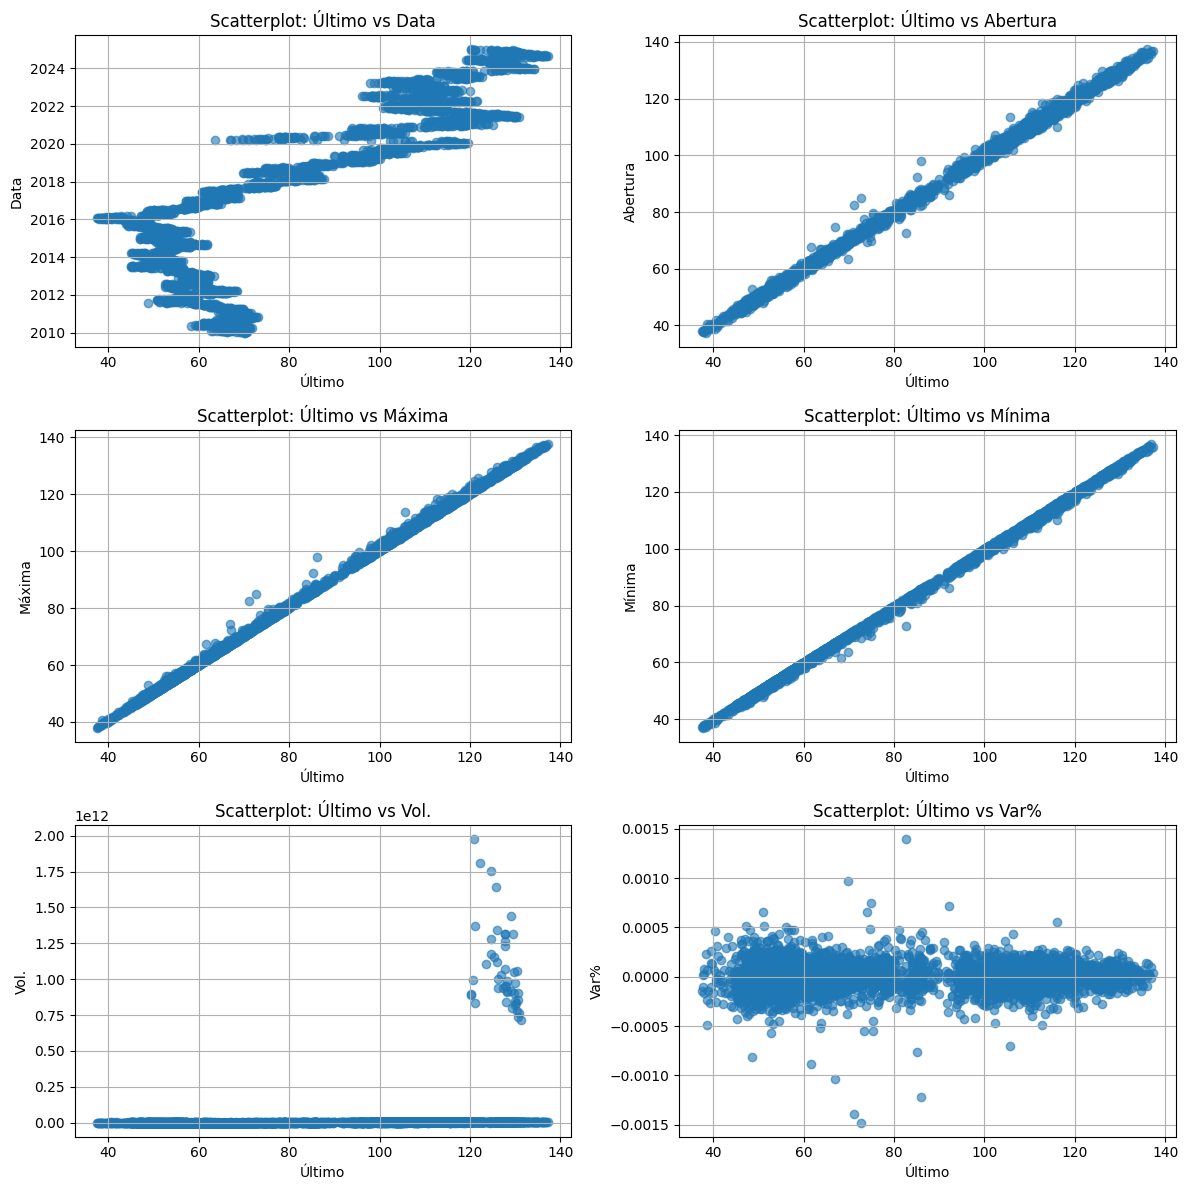

In [ ]:
variaveis = [col for col in df_ibovespa.columns if col != 'Último']

n_colunas = 2
n_linhas = math.ceil(len(variaveis) / n_colunas)

fig, axes = plt.subplots(n_linhas, n_colunas, figsize=(12, n_linhas * 4))
axes = axes.flatten()

for i, coluna in enumerate(variaveis):
    axes[i].scatter(df_ibovespa['Último'], df_ibovespa[coluna], alpha=0.6)
    axes[i].set_title(f"Scatterplot: Último vs {coluna}")
    axes[i].set_xlabel('Último')
    axes[i].set_ylabel(coluna)
    axes[i].grid(True)

for j in range(len(variaveis), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: >

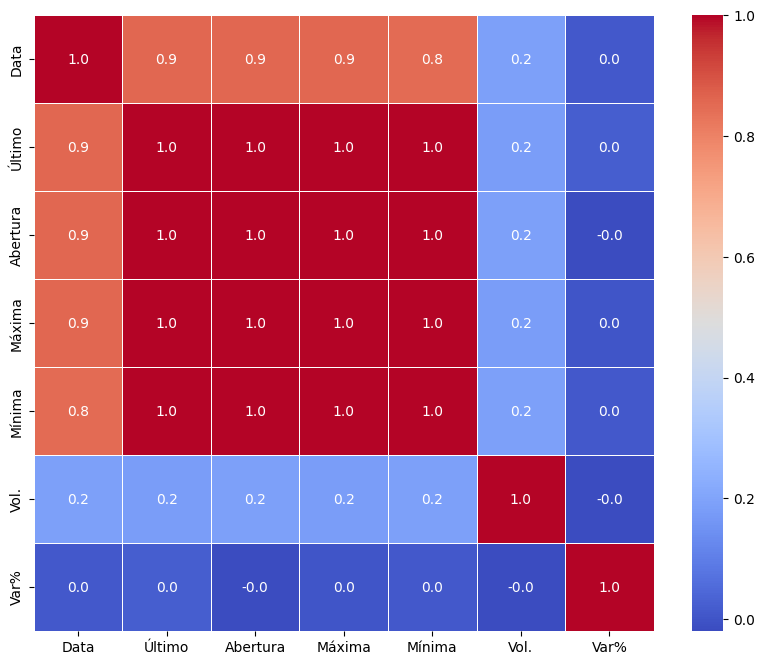

In [ ]:
matriz_corr = df_ibovespa.corr().round(2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=matriz_corr, annot=True, linewidths=.5, cmap='coolwarm', ax=ax, fmt='.1f')

In [ ]:
df_ibovespa = df_ibovespa.sort_values(by='Data')

## Modelagem

Realizamos uma extensa pesquisa sobre os algoritmos mais avançados e adequados para previsões financeiras, resultando na escolha de quatro modelos principais, cada um com características específicas.

### Treinando modelo - Algoritmo LSTM

O LSTM, uma rede neural especializada em séries temporais, mostrou-se especialmente promissor:

- Transformamos os dados em janelas temporais de 30 dias para prever o fechamento do dia seguinte.
- Foram ajustados hiperparâmetros como número de camadas e tamanho do batch para melhorar o desempenho.
- O LSTM capturou padrões complexos e dependências temporais de longo prazo, essenciais para dados financeiros.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

numerical_features = ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']
scaled_data = scaler.fit_transform(df_ibovespa[numerical_features])

scaled_df = pd.DataFrame(scaled_data, columns=numerical_features, index=df_ibovespa.index)
scaled_df['Data'] = df_ibovespa['Data']

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])  # Todas as colunas exceto a ultima (target)
        y.append(data[i+sequence_length, 0])      # Primeira coluna (target 'Último')
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 30  # Usar 30 registros anteriores para prever o proximo
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2)) # Apaga 20% dos neurônios da camada anterior
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2)) # Apaga 20% dos neurônios da segunda camada LSTM
lstm_model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

***Escolhemos o optimizer 'adam' por ser conhecido pela eficiência em lidar com dados ruidosos e complexos. Tambem converge rapidamente e requer menos ajuste manual do aprendizado.***

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0106 - val_loss: 0.0074
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0025 - val_loss: 8.7863e-04
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0017 - val_loss: 9.2229e-04
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0017 - val_loss: 7.8578e-04
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0016 - val_loss: 7.3881e-04
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 10/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 11/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0011 - val_loss: 7.0859e-04
Epoch 12/50
1

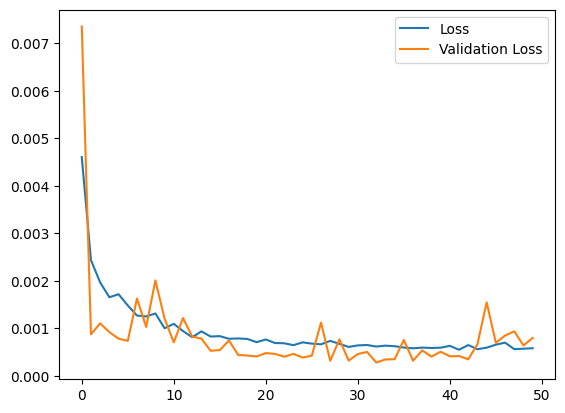

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
lstm_16_predictions = lstm_model.predict(X_test)
lstm_16_predictions = scaler.inverse_transform(np.hstack((lstm_16_predictions, np.zeros((lstm_16_predictions.shape[0], scaled_data.shape[1] - 1)))))[:, 0]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


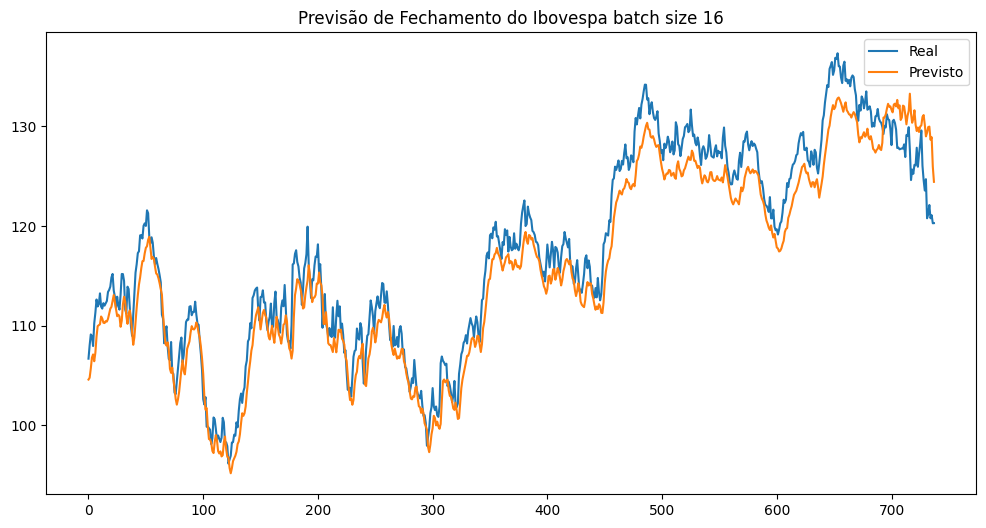

In [ ]:
# Visualizar os resultados
real_values = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)))))[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Real')
plt.plot(lstm_16_predictions, label='Previsto')
plt.legend()
plt.title('Previsão de Fechamento do Ibovespa batch size 16')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(real_values, lstm_16_predictions))
mae = mean_absolute_error(real_values, lstm_16_predictions)
r2 = r2_score(real_values, lstm_16_predictions)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

RMSE: 2.83, MAE: 2.41, R²: 0.92


In [ ]:
history2 = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.9214e-04 - val_loss: 4.6898e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 5.0180e-04 - val_loss: 6.9604e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.8571e-04 - val_loss: 5.0202e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.2588e-04 - val_loss: 6.9265e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 4.7722e-04 - val_loss: 5.5163e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 5.6107e-04 - val_loss: 6.9303e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 5.1592e-04 - val_loss: 5.4506e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 5.1985e-04 - val_loss: 5.9751e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 5.3013e-04 - val_loss: 6.8595e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.5844e-04 - val_loss: 6.7545e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.1668e-0

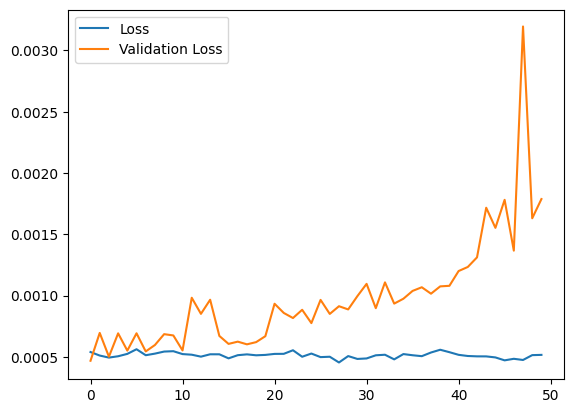

In [ ]:
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1)))))[:, 0]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


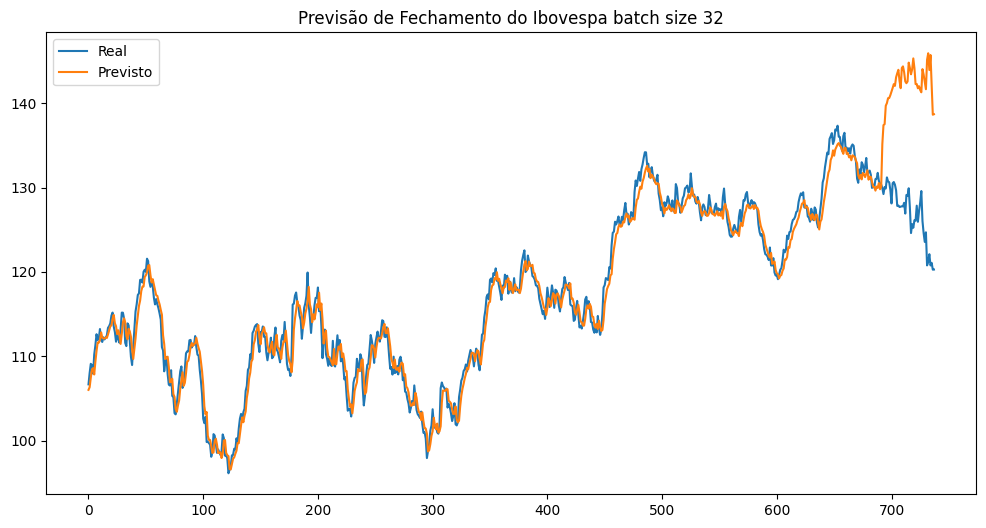

In [ ]:
# Visualizar os resultados
real_values = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)))))[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Real')
plt.plot(predictions, label='Previsto')
plt.legend()
plt.title('Previsão de Fechamento do Ibovespa batch size 32')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(real_values, predictions))
mae = mean_absolute_error(real_values, predictions)
r2 = r2_score(real_values, predictions)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

RMSE: 4.22, MAE: 2.07, R²: 0.82


### Treinando modelo - Algoritmo XGBoost

Reconhecido por sua eficiência em aprendizado supervisionado:

- Os dados foram estruturados em formato tabular.
- Realizamos grid search para encontrar a melhor combinação de hiperparâmetros.
- O XGBoost mostrou boa capacidade de modelar relações não lineares.

In [ ]:
# Achatar os dados para 2D
n_samples, sequence_length, n_features = X_train.shape
X_train_flat = X_train.reshape(n_samples, sequence_length * n_features)
X_test_flat = X_test.reshape(X_test.shape[0], sequence_length * n_features)

# Treinamento do modelo XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1500, learning_rate=0.01, max_depth=7, subsample=1.0, colsample_bytree=0.7, random_state=42)
xgb_model.fit(X_train_flat, y_train)

# Previsões
xgb_pred = xgb_model.predict(X_test_flat)

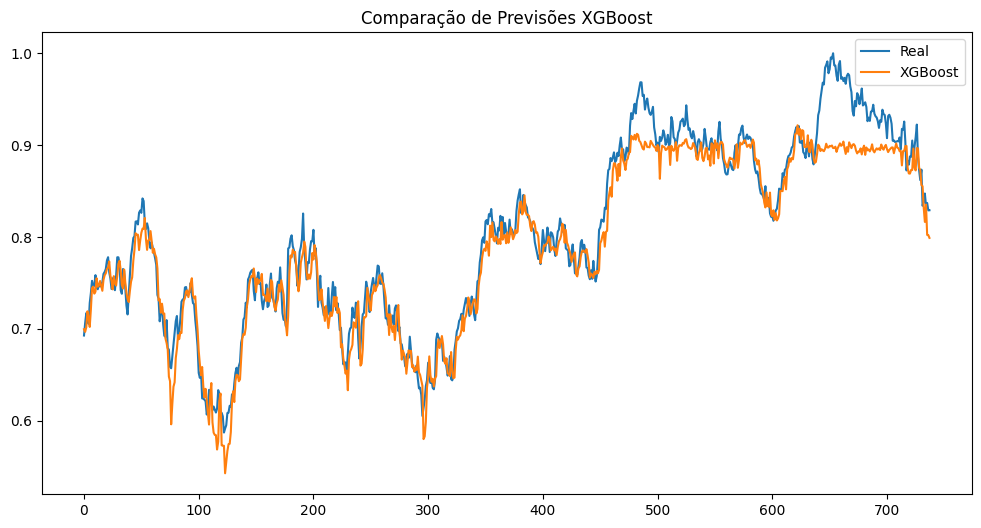

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Real')
plt.plot(xgb_pred, label='XGBoost')
plt.legend()
plt.title('Comparação de Previsões XGBoost')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

RMSE: 0.03, MAE: 0.02, R²: 0.93


### Treinando modelo - Algoritmo Random Forest

Modelo baseado em árvores de decisão, robusto e fácil de interpretar:

- Configurado com diferentes números de árvores e profundidades para avaliar o desempenho.
- Funcionou bem para identificar relações mais simples entre as variáveis.

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_flat, y_train)

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)

# Train the model
model.fit(X_train_flat, y_train)

# Make predictions
predictions = model.predict(X_test_flat)

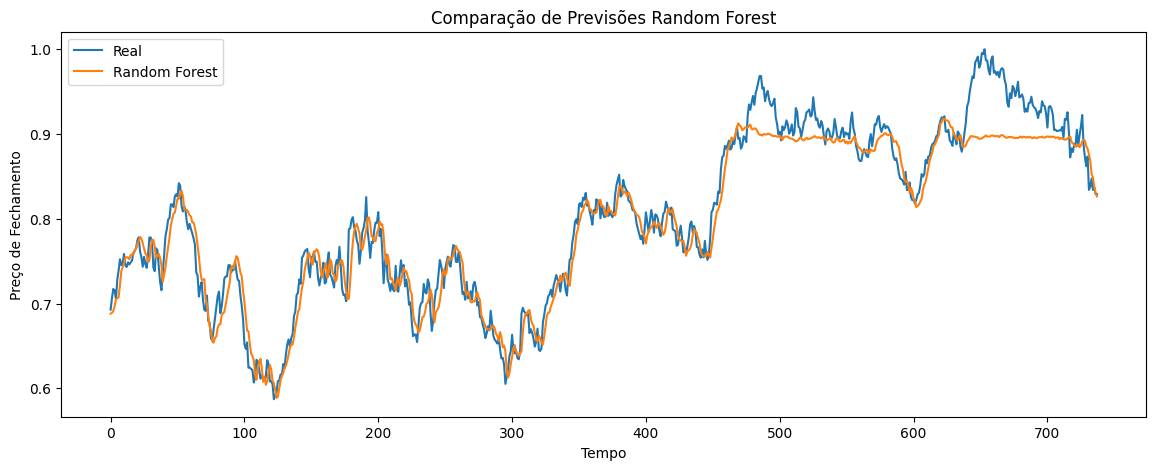

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y_test, label='Real')
plt.plot(predictions, label='Random Forest')
plt.title('Comparação de Previsões Random Forest')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

RMSE: 0.03, MAE: 0.02, R²: 0.93


### Treinando modelo - Algoritmo SARIMAX

Abordagem clássica para séries temporais, focada em sazonalidades:

- Ajustado para considerar a sazonalidade anual e variáveis externas, como volume e variação percentual.
- Testamos diferentes combinações de parâmetros (p, d, q) para minimizar o erro de previsão.
- Foi eficaz para capturar tendências de longo prazo e sazonalidades, mas menos adaptável a mudanças rápidas no mercado.

In [ ]:
df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
3716,2010-01-04,70.045,68.587,70.081,68.587,166000000.0,0.000212
3715,2010-01-05,70.240,70.046,70.595,69.928,198000000.0,0.000028
3714,2010-01-06,70.729,70.236,70.937,70.016,224000000.0,0.000070
3713,2010-01-07,70.451,70.723,70.723,70.045,155000000.0,-0.000039
3712,2010-01-08,70.263,70.455,70.766,70.158,163000000.0,-0.000027


In [ ]:
df_ibovespa.set_index('Data', inplace=True)

In [ ]:
common_index = df_ibovespa.dropna().index
endog = df_ibovespa.loc[common_index, 'Último']
exog = df_ibovespa.loc[common_index,['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']]

In [ ]:
endog, exog = df_ibovespa['Último'].align(df_ibovespa[['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']], join='inner')

In [ ]:
exog = exog.reindex(endog.index)

In [ ]:
exog = exog.fillna(0)  # Ou remova linhas com NaN
endog = endog.fillna(0)

In [ ]:
model = SARIMAX(
    df_ibovespa['Último'].dropna(),  # serie temporal (diferenciada)
    order=(1, 1, 1),  # parametros ARIMA (p, d, q)
    seasonal_order=(1, 1, 1, 7),  # parametros sazonais (P, D, Q, m)
    exog=exog,  # variaveis exogenas
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Previsão histórica para o dataset
df_ibovespa['predict'] = results.predict(
    start=df_ibovespa.index[1],  # Usar a primeira data após o índice inicial
    end=df_ibovespa.index[-1],    # Usar a última data no índice
    # Usar .loc para acessar as linhas pelas datas
    exog=df_ibovespa.loc[df_ibovespa.index[1:], ['Abertura', 'Máxima',
                               'Mínima', 'Vol.', 'Var%']]
)

# Usar o último registro como future_exog (última linha de dados)
future_exog = df_ibovespa.loc[df_ibovespa.index[-1], ['Abertura', 'Máxima', 'Mínima',
                                    'Vol.', 'Var%']].values.reshape(1, -1)

# Previsão do próximo fechamento
forecast = results.forecast(steps=1, exog=future_exog)

# Verificar se o forecast é do tipo Series
if isinstance(forecast, pd.Series):
    forecast_value = forecast.iloc[0]  # Acessar o primeiro valor da Series
else:
    # Caso seja um array simples, acessar diretamente
    forecast_value = forecast[0]

# Exibir a previsão
print(f"Previsão do próximo fechamento: {forecast_value}")

Previsão do próximo fechamento: 120.13074830424893


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Verificar se as séries de 'Último' e 'Predict' estão alinhadas
df_aligned = df_ibovespa[['Último', 'predict']].dropna()

# Cálculo do MAE e RMSE
mae = mean_absolute_error(df_aligned['Último'], df_aligned['predict'])
rmse = np.sqrt(mean_squared_error(df_aligned['Último'], df_aligned['predict']))
r2 = r2_score(df_aligned['Último'], df_aligned['predict'])

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

MAE: 0.28715577728740793
RMSE: 0.3937975728879122
R2 Score: 0.9997932275818707


### Avaliação

Avaliamos os modelos com base nas métricas:

- **Gráficos Real x Previsto**: Gráficos de linha que mostram tanto os dados reais quanto os dados previstos sobrepostos, para vermos as diferenças entre eles.

- **RMSE** (Root Mean Square Error): É a raiz quadrada do erro médio ao quadrado. Mede o desvio padrão das diferenças entre os valores preditos pelo modelo e os valores reais.

- **MAE** (Mean Absolute Error): É a média dos valores absolutos dos erros. Mede o erro médio em termos absolutos sem levar em conta o sinal (positivo ou negativo).

- **R²** (Coeficiente de Determinação): Mede o quão bem o modelo explica a variabilidade dos dados reais. É uma métrica de ajuste geral.

## Resultados

LSTM - RMSE: 2.83, MAE: 2.41, R²: 0.92

XGBoost - RMSE: 0.03, MAE: 0.02, R²: 0.93

Random Forest - RMSE: 0.03, MAE: 0.02, R²: 0.93

SARIMAX - RMSE: 0.39, MAE: 0.28, R²: 0.99

Embora os modelos Random Forest e LSTM tenham apresentado resultados competitivos, optamos pelo XGBoost devido ao seu equilíbrio entre precisão, eficiência computacional e capacidade de generalização. A robustez e a simplicidade de interpretação o tornaram ideal para nosso objetivo.

O modelo SARIMAX acabou tendo resultados extremamente elevados, entao optamos por não usar ele devido a alta chance de overfitting.

## **Conclusão**

Após uma avaliação criteriosa, optamos pelo XGBoost como modelo final para prever o fechamento diário do Ibovespa. A decisão foi fundamentada em sua capacidade de lidar com dados financeiros de forma robusta, eficiente e precisa.

Diferentemente de abordagens como o LSTM, que são mais complexas e exigem maior poder computacional, o XGBoost combina:

* Interpretação simplificada: Permite extrair insights claros das variáveis mais relevantes.

* Eficiência computacional: Reduz o tempo de treinamento e execução, fundamental para cenários dinâmicos.

* Versatilidade em relações não lineares: Mostrou-se particularmente eficaz em modelar as nuances do mercado financeiro.

* Desempenho competitivo: A acurácia e as métricas robustas obtidas reforçam sua confiabilidade para previsões no mercado financeiro.

Essa escolha oferece à equipe da Aurora Capital uma ferramenta estratégica que alia precisão e praticidade, capacitando decisões embasadas e eficazes em um ambiente de constante volatilidade.

 Referências:

- INVESTING.COM. Dados históricos do Ibovespa. Disponível em: https://br.investing.com/indices/bovespa-historical-data.
- SCIKIT-LEARN. Documentação oficial. Disponível em: [https://scikit-learn.org/stable/documentation.html](https://www.tensorflow.org/?hl=pt-brhttps%3A%2F%2Fscikit-learn.org%2Fstable%2Fdocumentation.html).
- TENSORFLOW. Guia oficial. Disponível em: [https://www.tensorflow.org/](https://www.tensorflow.org/?hl=pt-br).